In [1]:
import os
import subprocess
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from utils import mnist

In [2]:
# Если доступна видеокрта - будем считаться на ней
# Если нет - на ЦПУ
# Обязательно используем .to(device) на torch.tensor()

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(subprocess.getoutput("nvidia-smi"))
    print()
    print(f"GPUs in  system:        {torch.cuda.device_count()}")
    print(f"GPU compute capability: {torch.cuda.get_device_capability(device)}")
    print(f"GPU name:               {torch.cuda.get_device_name()}")
else:
    device = torch.device('cpu')
device

Mon May 18 12:37:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 206...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P8    15W / 184W |   1070MiB /  7981MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

device(type='cuda', index=0)

In [3]:
# Описываем класс, создающий сеть
class Net(nn.Module):
    # по умолчанию log_softmax = False
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        inputs=28*28
        l1_hidden_neurons=128
        outputs=10
        self.fc1 = nn.Linear(inputs, l1_hidden_neurons)
        self.act1 = torch.nn.Sigmoid() # именно эта строка не используется в forward, дописал для понимания последовательности действий
        self.fc2 = nn.Linear(l1_hidden_neurons, outputs)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=1.0)
        
    def forward(self, x):
        # на вход поступает набор картинок, размерность тензора (N, 28, 28)
        # нужно "выпрямить" в размерность (N, 28*28)
        x = x.view(-1, 28*28)
        
        # тут два шага в одном - суммируем данные первым слоем и сразу же пропускаем через активацию
        x = torch.sigmoid(self.fc1(x))
        
        # суммируем выходы последнего слоя
        x = self.fc2(x)
        
        # и в зависимости от запрошенного, используем разные softmax'ы
        if self.log_softmax:
            # если указали log_softmax=True
            x = F.log_softmax(x, dim=1) # log_softmax
        else:
            # по умолчанию
            x = torch.log(F.softmax(x, dim=1)) # log от softmax
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
def train(models, epoch, train_stats):
    # читаем батчами по 50 экземпляров каждый (настройки dataset_loader)
    for batch_idx, (data, target) in enumerate(train_loader):
        # данные перемещаем на нужное устройство (CPU/GPU)
        data = data.to(device)
        target = target.to(device)
        
        # на одном и том же батче обучаем каждую модель
        # это экономит время на передачу данных в\из памяти
        for model in models:
            # обнулили накопленные градиенты
            model.optim.zero_grad()
            # посчитали ответы сети с текущими весами
            output = model.forward(data)
            # посчитали ошибку
            loss = model.loss(output, target)
            # посчитали градиент
            loss.backward()
            # и проапдейтили веса новыми значениями 
            model.optim.step()
        
        # раз в (batch_size * 200) == 10000 выведем статистику  
        if batch_idx % 200 == 0:
            epoch_stats = f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({round(100. * batch_idx / len(train_loader), 2)}%)]\t\t"
            loss_stats = f"Losses: "
            for idx, model in enumerate(models):
                train_stats[idx] += [model._loss.item()]
                loss_stats += f" {idx}: {round(model._loss.item(),4)}\t"
            #print(epoch_stats + loss_stats)
            
    # перед завершением функции покажем посленюю статистику, т.к. она не попала  в цикл        
    batch_idx += 1 # потому что индекс с нуля
    epoch_stats = f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({round(100. * batch_idx / len(train_loader), 2)}%)]\t\t"
    loss_stats = f"Losses: "
    for idx, model in enumerate(models):
        train_stats[idx] += [model._loss.item()]
        loss_stats += f" {idx}: {round(model._loss.item(),4)}\t"
    print(epoch_stats + loss_stats)

In [5]:
def test(models, test_stats):
    # будем считать статистики по каждой модели отдельно
    test_loss = [0]*len(models) # сюда накапливать величину лосса
    correct = [0]*len(models) # а сюда плюсовать правильные ответы
    with torch.no_grad():
        for data, target in test_loader:
            # тестовые данные закидываем на CPU\GPU:
            data = data.to(device)
            target = target.to(device)
            
            # смотрим какие ответы нам дает каждая модель на тестовой выборке:
            output = []
            for model in models:
                output += [model.forward(data)]

            # теперь подсчтаем статистики для каждой модели
            for i, model in enumerate(models):
                # запишем сумму ошибок каждой модели
                test_loss[i] += model.loss(output[i], target, reduction='sum').item()
                # запишем индекс самого вероятного класса каждой модели
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                # плюсик в правильные ответы модели если ответ совпал с правильным
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    # посчитали сумму лосса и количество правильных ответов каждой модели
    for i in range(len(models)):
        # теперь усредним лосс каждой модели
        test_loss[i] /= len(test_loader.dataset)
    # сумму правильных ответов каждой модели делим на воличество примеров, получаем процент правильных ответов каждой модели в массив
    correct_pct = [100. * c / len(test_loader.dataset) for c in correct]
    # и вывод результата подсчета
    # 0: Loss: 0.1010	Accuracy: 9679/10000 (97%)
    lines =""
    for i, model in enumerate(models):
        test_stats[i] += [test_loss[i]]
        lines += f"Model #{i}\t Loss: {round(test_loss[i],4)}\t "
        lines += f"Accuracy:{correct[i]}/{len(test_loader.dataset)} "
        lines += f"({round(correct_pct[i].item(),2)}%)\n"
    report = 'Test set:\n' + lines
    
    print(report)

In [6]:
# Загрузим датасет MNIST, процедура загрузки описана в допфайле utils.py
train_loader, test_loader = mnist()

In [7]:
%%time
# создадим две модели, первая с log(softmax), вторая с log_softmax
models = [Net().to(device), Net(True).to(device)]

epoch_count = 2

# будем накапливать статистику для построения графиков
train_stats = []
test_stats = []
# зададим массив так, чтобы первым элементом накапливался массив по первой модели, вторым по второй и т.д.
for i, model in enumerate(models):
    train_stats += [[]]
    test_stats += [[]]

# стартуем обучение сетей
for epoch in range(1, epoch_count+1):
    train(models, epoch, train_stats)
    test(models,test_stats)
    
# убрали модель с карты
torch.cuda.empty_cache()

Train Epoch: 1 [60000/60000 (100.0%)]		Losses:  0: 0.1415	 1: 0.1054	
Test set:
Model #0	 Loss: 0.1581	 Accuracy:9496/10000 (94.96%)
Model #1	 Loss: 0.1399	 Accuracy:9582/10000 (95.82%)

Train Epoch: 2 [60000/60000 (100.0%)]		Losses:  0: 0.0296	 1: 0.0229	
Test set:
Model #0	 Loss: 0.1061	 Accuracy:9684/10000 (96.84%)
Model #1	 Loss: 0.1059	 Accuracy:9680/10000 (96.8%)

CPU times: user 31.9 s, sys: 753 ms, total: 32.6 s
Wall time: 32.5 s


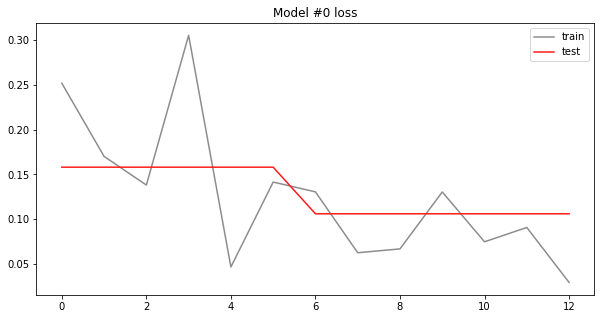

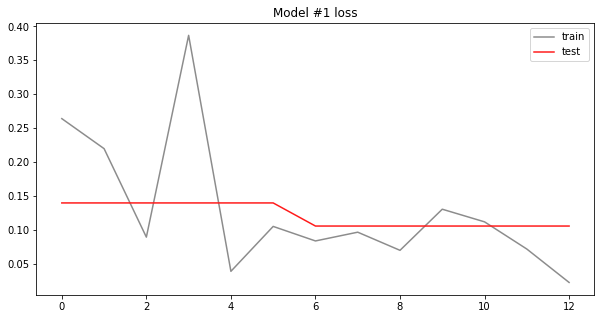

In [8]:
for i, model in enumerate(models):
    train_stats[i].pop(0)
    normalized_test_stats = []
    for j in test_stats[i]:
        normalized_test_stats.extend([j]*7)
    normalized_test_stats.pop(0)
    plt.figure(figsize=(10,5))
    plt.title(f"Model #{i} loss")
    plt.plot(train_stats[i], linestyle="-", color=[0.1, .1, .1, .5], label="train")
    plt.plot(normalized_test_stats, linestyle="-", color=[1, .1, .1, 1.0], label="test")
    plt.legend(loc="upper right")
    plt.show()

# А теперь переобучим сеть
### Будем менять количество нейронов, learning rate и количество эпох

In [9]:
# Описываем класс, создающий сеть
class Net(nn.Module):
    # по умолчанию log_softmax = False
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        inputs=28*28
        l1_hidden_neurons=512
        outputs=10
        self.fc1 = nn.Linear(inputs, l1_hidden_neurons)
        
        self.fc_out = nn.Linear(l1_hidden_neurons, outputs)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=2)
        
    def forward(self, x):
        # на вход поступает набор картинок, размерность тензора (N, 28, 28)
        # нужно "выпрямить" в размерность (N, 28*28)
        x = x.view(-1, 28*28)
        
        # тут два шага в одном - суммируем данные первым слоем и сразу же пропускаем через активацию
        x = torch.sigmoid(self.fc1(x))
                
        # суммируем выходы последнего слоя
        x = self.fc_out(x)
        
        # и в зависимости от запрошенного, используем разные softmax'ы
        if self.log_softmax:
            # если указали log_softmax=True
            x = F.log_softmax(x, dim=1) # log_softmax
        else:
            # по умолчанию
            x = torch.log(F.softmax(x, dim=1)) # log от softmax
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [10]:
%%time
# Достаточно одной модели с log_softmax
models = [Net(True).to(device)]

epoch_count = 500

# будем накапливать статистику для построения графиков
train_stats = []
test_stats = []
# зададим массив так, чтобы первым элементом накапливался массив по первой модели, вторым по второй и т.д.
for i, model in enumerate(models):
    train_stats += [[]]
    test_stats += [[]]

# стартуем обучение сетей
for epoch in range(1, epoch_count+1):
    train(models, epoch, train_stats)
    test(models,test_stats)

# убрали модель с карты
torch.cuda.empty_cache()

Train Epoch: 1 [60000/60000 (100.0%)]		Losses:  0: 0.1006	
Test set:
Model #0	 Loss: 0.1764	 Accuracy:9449/10000 (94.49%)

Train Epoch: 2 [60000/60000 (100.0%)]		Losses:  0: 0.1099	
Test set:
Model #0	 Loss: 0.1437	 Accuracy:9567/10000 (95.67%)

Train Epoch: 3 [60000/60000 (100.0%)]		Losses:  0: 0.1297	
Test set:
Model #0	 Loss: 0.1381	 Accuracy:9576/10000 (95.76%)

Train Epoch: 4 [60000/60000 (100.0%)]		Losses:  0: 0.0306	
Test set:
Model #0	 Loss: 0.1272	 Accuracy:9603/10000 (96.03%)

Train Epoch: 5 [60000/60000 (100.0%)]		Losses:  0: 0.0739	
Test set:
Model #0	 Loss: 0.1199	 Accuracy:9633/10000 (96.33%)

Train Epoch: 6 [60000/60000 (100.0%)]		Losses:  0: 0.1176	
Test set:
Model #0	 Loss: 0.1113	 Accuracy:9666/10000 (96.66%)

Train Epoch: 7 [60000/60000 (100.0%)]		Losses:  0: 0.0503	
Test set:
Model #0	 Loss: 0.1108	 Accuracy:9673/10000 (96.73%)

Train Epoch: 8 [60000/60000 (100.0%)]		Losses:  0: 0.0967	
Test set:
Model #0	 Loss: 0.1192	 Accuracy:9651/10000 (96.51%)

Train Epoch: 9 [

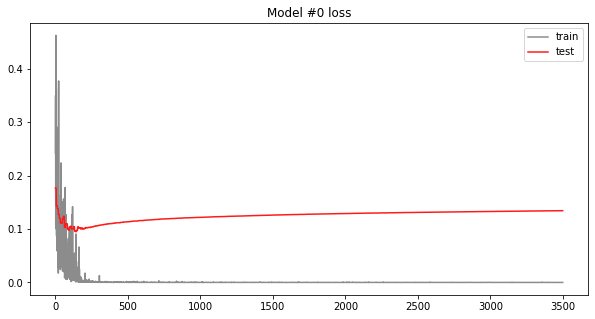

In [11]:
for i, model in enumerate(models):
    train_stats[i].pop(0)
    normalized_test_stats = []
    for j in test_stats[i]:
        normalized_test_stats.extend([j]*7)
    normalized_test_stats.pop(0)
    plt.figure(figsize=(10,5))
    plt.title(f"Model #{i} loss")
    plt.plot(train_stats[i], linestyle="-", color=[0.1, .1, .1, .5], label="train")
    plt.plot(normalized_test_stats, linestyle="-", color=[1, .1, .1, 1.0], label="test")
    plt.legend(loc="upper right")
    plt.show()